In [2]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# Dataset
# We want to normalize for each channels. Should add normalizing code here in the data loader
class CIFAR10WithID(datasets.CIFAR10):
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        return img, label, index

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # Mirror images
    transforms.RandomRotation(15),       # Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Change brightness
    transforms.RandomCrop(32, padding=4),  # Random crops
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train = CIFAR10WithID(root="./data", train=True, download=True, transform=transform)
test = CIFAR10WithID(root="./data", train=False, download=True, transform=transform)
# train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
# test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Data Loader
train_data_loader  = torch.utils.data.DataLoader(train, batch_size=64,shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test, batch_size=64,shuffle=False)

In [7]:
images, labels, id = next(iter(train_data_loader))

In [8]:
print(labels[0].item())

0


In [9]:
class ResNet_Block(torch.nn.Module): # This signifies one block with one skip connection
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResNet_Block, self).__init__()
        self.convolution1 = torch.nn.Sequential(
                                torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding=1), # Here the stride is not 1 because we might be coming from a bigger image size and we might need to downsample
                                torch.nn.BatchNorm2d(out_channels),
                                torch.nn.ReLU())
        self.convolution2 = torch.nn.Sequential(
                                torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1), # Here the stride is always 1 because this is the second conv layer is not downsampled
                                torch.nn.BatchNorm2d(out_channels))
        self.downsample = downsample # This will be not none if we are now changing. (Now we have a new block configuration)
        self.relu = torch.nn.ReLU()
        self.out_channels = out_channels


    def forward(self, x):
        res = x
        if self.downsample is not None:
            res = self.downsample(x)

        out1 = self.convolution1(x)
        out2 = self.convolution2(out1)
        z = out2 + res
        z = self.relu(z)

        return z



In [10]:
class ResNet(torch.nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.block = block
        # Input = 3 channels, 32 * 32
        self.convolution1 = torch.nn.Sequential(
                                torch.nn.Conv2d(3, 64, kernel_size = 5, stride = 1, padding = 2),
                                torch.nn.BatchNorm2d(64),
                                torch.nn.ReLU()) # 32*32
        self.maxpool = torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self.add_res_net_block(64, 64, layers[0], first_layer_stride = 1) # 32*32
        self.layer1 = self.add_res_net_block(64, 128, layers[1], first_layer_stride = 2)# 16*16
        self.layer2 = self.add_res_net_block(128, 256, layers[2], first_layer_stride = 2)#8*8
        self.avgpool = torch.nn.AvgPool2d(8, stride=1)
        self.fc = torch.nn.Linear(256, 10)

    def add_res_net_block(self, in_channels, out_channels, num_layers, first_layer_stride):
        downsample = None
        if first_layer_stride != 1 or in_channels != out_channels:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride=first_layer_stride),
                torch.nn.BatchNorm2d(out_channels)
            )
        block_layers = []
        block_layers.append(self.block(in_channels, out_channels, first_layer_stride, downsample))
        for _ in range(num_layers-1):
            block_layers.append(self.block(out_channels, out_channels, 1, None))

        return torch.nn.Sequential(*block_layers)

    def forward(self, x):
        x = self.convolution1(x)
        # x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [13]:
model = ResNet(ResNet_Block, [4, 4, 3]).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, weight_decay = 0.0001, momentum=0.8)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [17]:
train_loss = []
test_loss = []
train_accuracies = []
test_accuracies = []
for epoch in range(45):
  trainloss = 0.0
  testloss = 0.0
  test_correct = 0
  train_correct = 0
  test_total = 0
  train_total = 0
  model.train() # telling python that we are intereseted in updating any trainable parameters in the network

  for images, labels, indices in train_data_loader:
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad() # makes sure we have zeroes out gradients for trainable parameters from the previous iteration
    pred = model(images) # forward pass
    fit = loss(pred, labels)
    fit.backward() # backward pass
    optimizer.step() # updates the weight
    trainloss += fit.item()
    _, predicted = torch.max(pred, 1)
    train_correct += (predicted == labels).sum().item()
    train_total += labels.size(0)
  scheduler.step()
  model.eval()
  for images, labels, indices in test_data_loader:
    with torch.no_grad():
      images = images.to(device)
      labels = labels.to(device)
      pred = model(images)
      fit = loss(pred, labels)
      testloss += fit.item()
      _, predicted = torch.max(pred, 1)
      test_correct += (predicted == labels).sum().item()
      test_total += labels.size(0)
      # for id, label in zip(indices, pred):
      #   data_list.append([id, label])


  trainloss = trainloss/len(train_data_loader)
  testloss = testloss/len(test_data_loader)

  train_loss.append(trainloss)
  test_loss.append(testloss)

  test_accuracy = 100 * test_correct/test_total
  train_accuracy = 100 * train_correct/train_total
  test_accuracies.append(test_accuracy)
  train_accuracies.append(train_accuracy)

  print(f'Epoch: {epoch}, Train Loss: {trainloss:.2f}, Test loss: {testloss:.2f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

Epoch: 0, Train Loss: 0.21, Test loss: 0.39, Train Accuracy: 92.50%, Test Accuracy: 86.96%
Epoch: 1, Train Loss: 0.21, Test loss: 0.39, Train Accuracy: 92.58%, Test Accuracy: 86.88%
Epoch: 2, Train Loss: 0.21, Test loss: 0.39, Train Accuracy: 92.64%, Test Accuracy: 87.03%
Epoch: 3, Train Loss: 0.20, Test loss: 0.40, Train Accuracy: 92.91%, Test Accuracy: 86.80%
Epoch: 4, Train Loss: 0.20, Test loss: 0.39, Train Accuracy: 93.06%, Test Accuracy: 86.64%
Epoch: 5, Train Loss: 0.20, Test loss: 0.39, Train Accuracy: 93.17%, Test Accuracy: 87.33%
Epoch: 6, Train Loss: 0.20, Test loss: 0.39, Train Accuracy: 93.15%, Test Accuracy: 87.19%


KeyboardInterrupt: 

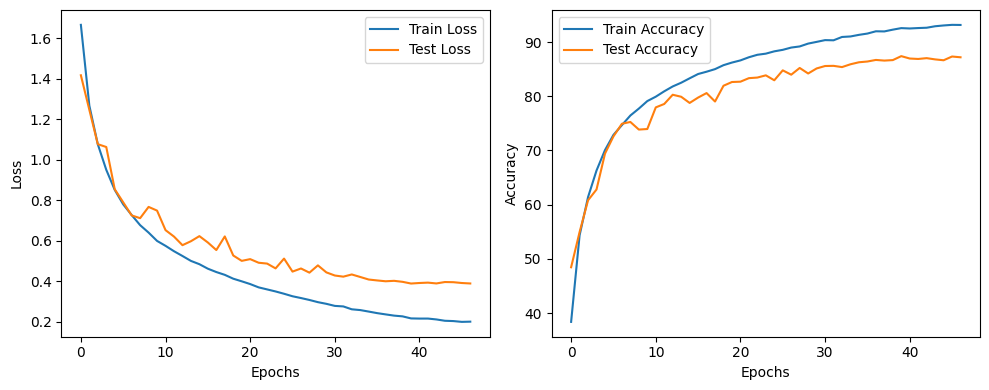

In [18]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(train_loss, label="Train Loss")
ax[0].plot(test_loss, label="Test Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(train_accuracies, label="Train Accuracy")
ax[1].plot(test_accuracies, label="Test Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.tight_layout()

In [21]:
# torch.save(model.state_dict(), './ResNet4_4_3.pth')

In [22]:
data_list = []

model.eval()
for images, labels, indices in test_data_loader:
  with torch.no_grad():
    images = images.to(device)
    labels = labels.to(device)
    pred = model(images)
    fit = loss(pred, labels)
    testloss += fit.item()
    _, predicted = torch.max(pred, 1)
    test_correct += (predicted == labels).sum().item()
    test_total += labels.size(0)
    for id, label in zip(indices.numpy(), predicted):
        data_list.append([id, label.item()])
df = pd.DataFrame(data_list, columns=["ID", "Labels"])
csv_file_path = 'data.csv'
df.to_csv(csv_file_path, index=False)